<a href="https://colab.research.google.com/github/kr5red/automated-customer-reviews/blob/main/main_ki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Product Review Sentiment Notebook (Classical Setup with Transformers)

This notebook is divided into different steps:

Step 1: Sentiment analysis, classifying the reviews in positive, negative and neutral through model 1: cardiffnlp/twitter-roberta-base-sentiment

1. Installs **transformers** and **pandas** dependencies.
2. Loads your CSV of reviews.
3. Merges `reviews.title` and `reviews.text` into `review_text`.
4. Light-cleans text, drops missing/duplicates.
5. Runs **cardiffnlp/twitter-roberta-base-sentiment** to get **negative/neutral/positive**.
6. Saves results to `reviews_with_sentiment.csv` and shows quick summaries.
7. Calculates accuracy.

Step 2: Product category clustering


## **STEP 1**

## 0) Install dependencies (run once)

In [33]:
device = -1  # force CPU

In [34]:

# If running locally, uncomment the next line to install once per environment.
# You may need to restart the kernel after first install.
# %%capture
!pip install -q --upgrade pip
!pip install -q pandas numpy transformers torch tqdm


## 1) Imports

In [35]:

import os
import re
import math
import pandas as pd
import numpy as np
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch


## 2) Load the Dataset

In [36]:

#Set up the csv_path
import pandas as pd
from pathlib import Path
import kagglehub
pd.set_option('display.max_columns', None)

# Download all files
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")
csv_paths = list(Path(path).glob("*.csv"))


dfs = [pd.read_csv(p) for p in csv_paths]
df = pd.concat(dfs, ignore_index=True)

df = df.drop_duplicates(
    subset=['id', 'dateAdded', 'dateUpdated', 'reviews.text', 'reviews.title', 'reviews.username'],
    keep='first'
)

print(df.shape)
df.head()


Using Colab cache for faster access to the 'consumer-reviews-of-amazon-products' dataset.


/tmp/ipython-input-1332930570.py:12: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in csv_paths]


(67896, 27)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.didPurchase,reviews.userCity,reviews.userProvince
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0.0,3.0,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0.0,4.0,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,177283626.0,3.0,5.0,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0.0,5.0,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN


## 3.1) Create unified "reviews_text" by merging title + text

In [37]:
#merge title and text
def merge_title_text(row):
    t1 = str(row.get("reviews.title") if pd.notna(row.get("reviews.title")) else "").strip()
    t2 = str(row.get("reviews.text") if pd.notna(row.get("reviews.text")) else "").strip()
    if t1 and t2:
        return f"{t1}. {t2}"
    return t1 or t2

df["review_text"] = df.apply(merge_title_text, axis=1)
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.didPurchase,reviews.userCity,reviews.userProvince,review_text
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0.0,3.0,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Too small. I thought it would be as big as sma...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Great light reader. Easy to use at the beach. ...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0.0,4.0,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Great for the price. Didnt know how much i'd u...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,177283626.0,3.0,5.0,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,A Great Buy. I am 100 happy with my purchase. ...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0.0,5.0,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Solid entry-level Kindle. Great for kids. Soli...


## 3.2) Cleaning

In [38]:
# Lowercase, strip URLs/emails, collapse whitespace
def clean_text(s: str) -> str:
    s = str(s)
    s = s.lower()
    s = re.sub(r"[^\w\s'.,!?-]", " ", s)  # keep common punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["review_text"].fillna("").apply(clean_text)

# Drop missing/empty
df = df[df["review_text"].str.len() > 0].copy()

# Drop exact duplicates of the clean text
before = len(df)
df = df.drop_duplicates(subset=["review_text"]).reset_index(drop=True)
after = len(df)
print(f"Dropped {before - after} duplicate rows. Remaining: {after}")
df.head()


Dropped 20576 duplicate rows. Remaining: 47320


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.didPurchase,reviews.userCity,reviews.userProvince,review_text
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0.0,3.0,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Too small. I thought it would be as big as sma...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Great light reader. Easy to use at the beach. ...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0.0,4.0,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Great for the price. Didnt know how much i'd u...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,177283626.0,3.0,5.0,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,A Great Buy. I am 100 happy with my purchase. ...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0.0,5.0,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Solid entry-level Kindle. Great for kids. Soli...


## 4) Load sentiment model

In [39]:

# Load chosen sentiment model: cardiffnlp/twitter-roberta-base-sentiment
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

model_name = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Max length safety: many RoBERTa-family models use 512 tokens (special tokens make the 514 you saw)
MAX_LEN = min(getattr(tokenizer, "model_max_length", 512), 512)

# Build id2label mapping robustly
id2label = getattr(model.config, "id2label", None)
if not id2label or not isinstance(id2label, dict) or len(id2label) < 3:
    id2label = {0: "negative", 1: "neutral", 2: "positive"}

# Use HF pipeline; we will pass truncation/padding at call time
pipe = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True
)


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## 5) Run inference in batches and collect predictions

In [40]:
from tqdm import tqdm

texts = df["review_text"].tolist()
batch_size = 16  # reduce if RAM is tight

pred_labels, pred_scores = [], []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    # 🔑 KEY: enforce truncation/padding and a safe max_length
    outputs = pipe(batch, truncation=True, padding=True, max_length=MAX_LEN)

    for scores in outputs:
        # pick top class
        best = max(scores, key=lambda d: d["score"])
        label = best["label"].lower()
        # Normalize labels if they come as LABEL_0/1/2
        if label.startswith("label_"):
            idx = int(label.split("_")[-1])
            label = id2label.get(idx, str(idx)).lower()
        if label not in {"negative", "neutral", "positive"}:
            # fallback via rank order if labels are unexpected
            idx = scores.index(best)
            label = id2label.get(idx, "neutral").lower()

        pred_labels.append(label)
        pred_scores.append(float(best["score"]))

df["sentiment_model_labels"] = pred_labels
df["sentiment_model_confidence"] = pred_scores

100%|██████████| 2958/2958 [06:46<00:00,  7.27it/s]


In [41]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.didPurchase,reviews.userCity,reviews.userProvince,review_text,sentiment_model_labels,sentiment_model_confidence
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0.0,3.0,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Too small. I thought it would be as big as sma...,label_0,0.690747
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Great light reader. Easy to use at the beach. ...,label_2,0.984449
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0.0,4.0,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Great for the price. Didnt know how much i'd u...,label_2,0.949640
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,177283626.0,3.0,5.0,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,A Great Buy. I am 100 happy with my purchase. ...,label_2,0.934534
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0.0,5.0,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...,NaN,NaN,NaN,Solid entry-level Kindle. Great for kids. Soli...,label_2,0.983082


## 6) Save results

In [42]:

out_path = "reviews_with_sentiment_model.csv"
df.to_csv(out_path, index=False)
out_path, df.shape


('reviews_with_sentiment_model.csv', (47320, 30))

## 7) Quick summary & sanity checks

In [43]:

print(df["sentiment_model_labels"].value_counts(dropna=False))
df.sample(5, random_state=42)[["reviews.title", "reviews.text", "review_text", "sentiment_model_labels", "sentiment_model_confidence"]]



sentiment_model_labels
label_2    42955
label_0     2485
label_1     1880
Name: count, dtype: int64


,reviews.title,reviews.text,review_text,sentiment_model_labels,sentiment_model_confidence
8790,Great for Readers,I bought this for my daughter. She loves it! S...,Great for Readers. I bought this for my daught...,label_2,0.988677
16840,Good starter tablet,I bought this product as a Christmas gift and ...,Good starter tablet. I bought this product as ...,label_2,0.986684
29906,Not quite there,Alexa is OK for basic weather and turning on/o...,Not quite there. Alexa is OK for basic weather...,label_2,0.588906
25565,"Great device, kids love it!","Device is great, easy setup (less than 10 minu...","Great device, kids love it!. Device is great, ...",label_2,0.980153
42618,So fare working great.,Got these for some LED motion lights. So fare ...,So fare working great.. Got these for some LED...,label_2,0.970427


### 8) Classification

In [44]:

# Map ratings (1–5) to sentiment
def sentiment_through_rating(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment_ratings_true"] = df["reviews.rating"].apply(sentiment_through_rating)

def sentiment_through_model(r):
    if r == "label_02":
        return "postive"
    elif r == "label_01":
        return "neutral"
    else:
        return "positive"

df["sentiment_model"] = df["sentiment_model_labels"].apply(sentiment_through_model)

#   id2label = {0: "negative", 1: "neutral", 2: "positive"}
df.sample(5, random_state=42)[["reviews.rating" , "reviews.title", "reviews.text", "review_text", "sentiment_model_labels", "sentiment_model_confidence", "sentiment_model", "sentiment_ratings_true"]]

,reviews.rating,reviews.title,reviews.text,review_text,sentiment_model_labels,sentiment_model_confidence,sentiment_model,sentiment_ratings_true
8790,4.0,Great for Readers,I bought this for my daughter. She loves it! S...,Great for Readers. I bought this for my daught...,label_2,0.988677,positive,positive
16840,5.0,Good starter tablet,I bought this product as a Christmas gift and ...,Good starter tablet. I bought this product as ...,label_2,0.986684,positive,positive
29906,3.0,Not quite there,Alexa is OK for basic weather and turning on/o...,Not quite there. Alexa is OK for basic weather...,label_2,0.588906,positive,neutral
25565,5.0,"Great device, kids love it!","Device is great, easy setup (less than 10 minu...","Great device, kids love it!. Device is great, ...",label_2,0.980153,positive,positive
42618,5.0,So fare working great.,Got these for some LED motion lights. So fare ...,So fare working great.. Got these for some LED...,label_2,0.970427,positive,positive


## 9) Accuracy score

In [45]:
from sklearn.metrics import accuracy_score, classification_report

# Convert to string and handle missing values
y_true = df['sentiment_ratings_true'].astype(str)
y_pred = df['sentiment_model'].astype(str)

acc_score = accuracy_score(y_true, y_pred)
print(f"Accuracy Score: {acc_score:.4f}")


Accuracy Score: 0.9172


## **STEP 2:**

## 1) Imports

In [46]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

out_path = "reviews_with_sentiment.csv"
df.to_csv(out_path, index=False)
out_path, df.shape
print(df.shape)

(47320, 32)


## 2) Create unified "product_text" by merging name and keys


In [47]:
# Combine 'name' and 'keys' for richer descriptions
def combine_text(row):
    n = str(row.get("name", "")).strip()
    k = str(row.get("keys", "")).strip()
    return f"{n}. {k}" if k else n

df["product_text"] = df.apply(combine_text, axis=1)

# Drop empties and duplicates
df = df[df["product_text"].str.strip().astype(bool)]
df = df.drop_duplicates(subset=["product_text"]).reset_index(drop=True)

print("Unique product texts:", len(df))
df["product_text"].head(3)

Unique product texts: 157


,product_text
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation..."
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...


## 2) Load SentenceTransformer model to create text embeddings


In [48]:
model_emb = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = model_emb.encode(
    df["product_text"].tolist(),
    batch_size=32,
    show_progress_bar=True
)
print("Embeddings shape:", embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Embeddings shape: (157, 384)


## 3) Clustering

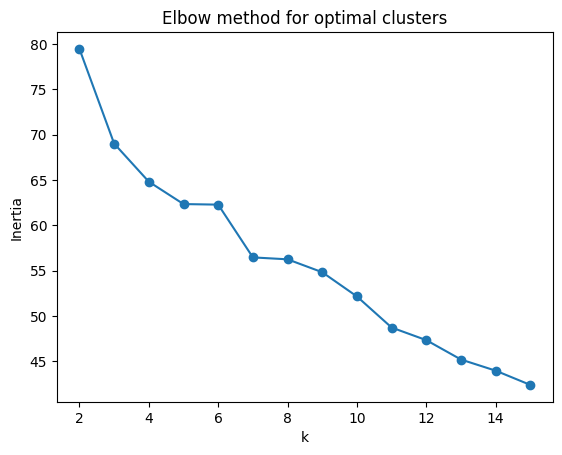

In [49]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Try a few cluster counts
inertias = []
K = range(2, 16)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(embeddings)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method for optimal clusters")
plt.show()
